### TA Suggestions 
* Perhaps with SPY or other indices
* perform an hourly training/5 min traning, etc. 
* store pre-trained model 
* current data for prediction
* load model
* get ticker name input
* predict usining model
* show results

In [289]:
# !pip install alpha_vantage

In [290]:
#Source: https://github.com/Derrick-Sherrill/DerrickSherrill.com/blob/master/stocks.py

import os
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import time
from path import Path
%matplotlib inline
from datetime import datetime as dt
from dateutil.tz import gettz
import re
import numpy as np
import pandas as pd
import hvplot.pandas
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
import keras
from newsapi import NewsApiClient

#!pip install alpha_vantage
# get API from alpha vantage
api_key_stocks = os.getenv("ALPHA_VANTAGE_API_KEY")

#import nltk
#nltk.download()
from nltk.corpus import reuters
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Read your api key environment variable
api_key_news = os.getenv("NEWS_API_KEY")
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key_news)


In [291]:
tickers = ['AAPL', 'DIS', 'MSFT', 'IBM']

# News Data

In [293]:
# Fetch the news articles for the chosen ticker
ticker = input ("Enter ticker :") 

news_headlines = newsapi.get_everything(
    q=ticker, language="en", sort_by="relevancy"
)



# Print total articles
print(f"Total articles about {ticker}: {news_headlines['totalResults']}")
# Show sample article
news_headlines["articles"][0]

Enter ticker : AAPL


Total articles about AAPL: 897


{'source': {'id': 'business-insider', 'name': 'Business Insider'},
 'author': 'Lisa Eadicicco',
 'title': 'Now is the worst time to buy a new Apple laptop (AAPL)',
 'description': "Apple is expected to launch a couple of new laptops in the coming months, including MacBook Pro and Air models that include the company's recently redesigned keyboard. Apple may also release new laptops based on its own custom chips for the first time in late…",
 'url': 'https://www.businessinsider.com/apple-macbook-pro-air-release-worst-time-to-buy-laptop-2020-3',
 'urlToImage': 'https://i.insider.com/5cd9d11f021b4c3cd02d2bc2?width=1200&format=jpeg',
 'publishedAt': '2020-03-14T12:00:00Z',
 'content': None}

In [294]:
news_df = pd.DataFrame.from_dict(news_headlines['articles'])
news_df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': 'business-insider', 'name': 'Business I...",Lisa Eadicicco,Now is the worst time to buy a new Apple lapto...,Apple is expected to launch a couple of new la...,https://www.businessinsider.com/apple-macbook-...,https://i.insider.com/5cd9d11f021b4c3cd02d2bc2...,2020-03-14T12:00:00Z,None
1,"{'id': 'business-insider', 'name': 'Business I...",Lisa Eadicicco,Apple is donating 9 million protective face ma...,Apple is donating 9 million protective face ma...,https://www.businessinsider.com/apple-tim-cook...,https://i.insider.com/5e7a965f0c2a6275d6005217...,2020-03-24T23:33:01Z,Apple is donating 9 million protective face ma...
2,"{'id': 'business-insider', 'name': 'Business I...",Lisa Eadicicco,Apple's retail stores are closed until further...,Apple's retail stores are currently closed unt...,https://www.businessinsider.com/apple-stores-c...,https://i.insider.com/5e70f2dcc485403371351254...,2020-03-17T15:57:16Z,Apple's retail stores are currently closed unt...
3,"{'id': 'business-insider', 'name': 'Business I...",Lisa Eadicicco,Apple's next major iPhone update could complet...,Apple is reportedly working on a new feature t...,https://www.businessinsider.com/apple-ios-14-r...,https://i.insider.com/5e8f93f98427e96ead4d9cf5...,2020-04-09T21:43:30Z,Apple's next major iPhone update could include...
4,"{'id': None, 'name': '9to5mac.com'}",Chance Miller,Analyst predicts year-end rebound for AAPL as ...,AAPL stock fell more than 12% at the market op...,https://9to5mac.com/2020/03/17/aapl-stock-jump...,https://9to5mac.com/wp-content/uploads/sites/6...,2020-03-17T21:41:23Z,AAPL stock fell more than 12% at the market op...


In [295]:
# Create the ticker sentiment scores DataFrame
sentiments = []

for article in news_headlines["articles"]:
    try:
        
        text = article["content"]
        date = article["publishedAt"]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        neg = sentiment["neg"]
        neu = sentiment["neu"]
        pos = sentiment["pos"]
        
        sentiments.append({
            "date": date,
            "Compound": compound,
            "Negative": neg,
            "Neutral": neu,
            "Positive": pos,
            "Text": text,
 
        })
        
    except AttributeError:
        pass
    
# Create DataFrame
sentiments_df = pd.DataFrame(sentiments)

# Reorder DataFrame columns
cols = ["date", "Compound", "Negative", "Neutral", "Positive", "Text"]
sentiments_df = sentiments_df[cols]

sentiments_df.tail()

,date,Compound,Negative,Neutral,Positive,Text
14,2020-03-30T13:58:13Z,-0.9079,0.224,0.776,0.000,Apple analysts Wedbush has said that the worst...
15,2020-03-18T15:41:40Z,-0.3612,0.080,0.920,0.000,AP Photo/Markus Schreiber\r\n<ul><li>Daniel Iv...
16,2020-03-16T12:00:00Z,0.5859,0.000,0.888,0.112,"After an onslaught of leaks, Apple's new Power..."
17,2020-03-16T11:00:00Z,-0.1027,0.033,0.967,0.000,Business Insider\r\nAs the coronavirus outbrea...
18,2020-04-02T16:13:46Z,0.6597,0.000,0.878,0.122,Apple is teaming up with philanthropist Lauren...


In [296]:
sentiments_df['date'] = pd.to_datetime(sentiments_df['date'], infer_datetime_format=True)
sentiments_df = sentiments_df.set_index(sentiments_df['date'])

In [297]:
sentiments = sentiments_df.drop(columns='date').sort_index()
sentiments.head()

,Compound,Negative,Neutral,Positive,Text
date,,,,,
2020-03-09 18:39:38,0.9081,0.000,0.734,0.266,Apple has updated its guidelines for how to sa...
2020-03-09 20:07:21,0.4767,0.000,0.931,0.069,CNBC\r\n<ul><li>Daniel Ives of Wedbush said in...
2020-03-09 21:50:03,-0.7579,0.152,0.794,0.055,"Amid a tumultuous day for U.S. stocks, AAPL en..."
2020-03-11 12:27:24,0.8381,0.000,0.808,0.192,Shares have taken something of a battering in ...
2020-03-12 13:44:16,0.2960,0.000,0.948,0.052,"Apple shares opened at $255.94 today, down jus..."


In [298]:
#sentiments['Date'] = pd.to_datetime(sentiments_df['date']).dt.date
#sentiments.reset_index(inplace=True)

In [299]:
#sentiments.set_index("Date", inplace=True)

In [300]:
#sentiments.sort_index()
#sentiments.head()

In [301]:
# Describe the ticker sentiment
sentiments.describe(include='all')

,Compound,Negative,Neutral,Positive,Text
count,19.000000,19.000000,19.000000,19.000000,19
unique,NaN,NaN,NaN,NaN,19
top,NaN,NaN,NaN,NaN,Shares have taken something of a battering in ...
freq,NaN,NaN,NaN,NaN,1
mean,0.190258,0.040158,0.879105,0.080789,NaN
std,0.581902,0.061472,0.073433,0.080529,NaN
min,-0.907900,0.000000,0.734000,0.000000,NaN
25%,-0.231950,0.000000,0.808500,0.000000,NaN
50%,0.296000,0.000000,0.888000,0.055000,NaN
75%,0.708800,0.055000,0.944500,0.135500,NaN


# Stock Data

In [303]:
ticker = input ("Enter ticker :") 

ts = TimeSeries(key=api_key_stocks, output_format='pandas')
data, meta_data = ts.get_intraday(symbol=ticker, interval = '5min', outputsize = 'full')

print(ticker, data)

Enter ticker : AAPL


AAPL                       1. open   2. high    3. low  4. close  5. volume
date                                                                  
2020-04-09 16:00:00  267.9500  268.4600  267.7500  268.0200   794179.0
2020-04-09 15:55:00  266.9000  268.4400  266.4100  267.9365   929164.0
2020-04-09 15:50:00  268.1600  268.3200  266.8906  266.9850   595111.0
2020-04-09 15:45:00  268.1850  268.8800  267.8000  268.1400   540341.0
2020-04-09 15:40:00  268.4600  268.6500  267.6100  268.1850   562958.0
...                       ...       ...       ...       ...        ...
2020-03-20 09:55:00  247.4600  249.4100  247.2750  248.8899   829296.0
2020-03-20 09:50:00  247.0100  248.2500  246.4700  247.5000   973936.0
2020-03-20 09:45:00  248.2600  249.0850  246.8763  246.8763  1010432.0
2020-03-20 09:40:00  248.9500  250.3143  247.6000  248.5400  1496488.0
2020-03-20 09:35:00  247.7945  248.9800  246.8400  248.9500  6170361.0

[1170 rows x 5 columns]


In [305]:
close_data = data['4. close']

In [306]:
percentage_change = close_data.pct_change().fillna(0)

In [307]:
#i = 1
#while i==1:
#    data, meta_data = ts.get_intraday(symbol='DIS', interval = '1min', outputsize = 'full')
#    data.to_excel("output.xlsx")
#    time.sleep(60)

print(percentage_change)

date
2020-04-09 16:00:00    0.000000
2020-04-09 15:55:00   -0.000312
2020-04-09 15:50:00   -0.003551
2020-04-09 15:45:00    0.004326
2020-04-09 15:40:00    0.000168
                         ...   
2020-03-20 09:55:00    0.002013
2020-03-20 09:50:00   -0.005584
2020-03-20 09:45:00   -0.002520
2020-03-20 09:40:00    0.006739
2020-03-20 09:35:00    0.001650
Name: 4. close, Length: 1170, dtype: float64


In [308]:
last_change = percentage_change[-1]
if abs(last_change) > 0.0004:
    print(f"{ticker} Alert: " + str(last_change))

AAPL Alert: 0.001649633861752653


In [309]:
quotes = data.sort_index()
quotes['6. change'] = percentage_change

In [310]:
quotes

,1. open,2. high,3. low,4. close,5. volume,6. change
date,,,,,,
2020-03-20 09:35:00,247.7945,248.9800,246.8400,248.9500,6170361.0,0.001650
2020-03-20 09:40:00,248.9500,250.3143,247.6000,248.5400,1496488.0,0.006739
2020-03-20 09:45:00,248.2600,249.0850,246.8763,246.8763,1010432.0,-0.002520
2020-03-20 09:50:00,247.0100,248.2500,246.4700,247.5000,973936.0,-0.005584
2020-03-20 09:55:00,247.4600,249.4100,247.2750,248.8899,829296.0,0.002013
...,...,...,...,...,...,...
2020-04-09 15:40:00,268.4600,268.6500,267.6100,268.1850,562958.0,0.000168
2020-04-09 15:45:00,268.1850,268.8800,267.8000,268.1400,540341.0,0.004326
2020-04-09 15:50:00,268.1600,268.3200,266.8906,266.9850,595111.0,-0.003551


In [311]:
quotes['7. increase'] = (quotes['6. change'] > 0).astype(int)
quotes

,1. open,2. high,3. low,4. close,5. volume,6. change,7. increase
date,,,,,,,
2020-03-20 09:35:00,247.7945,248.9800,246.8400,248.9500,6170361.0,0.001650,1
2020-03-20 09:40:00,248.9500,250.3143,247.6000,248.5400,1496488.0,0.006739,1
2020-03-20 09:45:00,248.2600,249.0850,246.8763,246.8763,1010432.0,-0.002520,0
2020-03-20 09:50:00,247.0100,248.2500,246.4700,247.5000,973936.0,-0.005584,0
2020-03-20 09:55:00,247.4600,249.4100,247.2750,248.8899,829296.0,0.002013,1
...,...,...,...,...,...,...,...
2020-04-09 15:40:00,268.4600,268.6500,267.6100,268.1850,562958.0,0.000168,1
2020-04-09 15:45:00,268.1850,268.8800,267.8000,268.1400,540341.0,0.004326,1
2020-04-09 15:50:00,268.1600,268.3200,266.8906,266.9850,595111.0,-0.003551,0


In [312]:
#quotes.reset_index(inplace=True)
#quotes['Date'] = quotes['date'].dt.date
#quotes.set_index('Date', inplace=True)

In [313]:
#quotes.sort_index()
#quotes.head()

# Join the Dataframes

In [314]:
df_outjoin = pd.concat([sentiments, quotes], axis=1, join='outer')
df_outjoin.reset_index(inplace=True)
df_outjoin['Date'] = df_outjoin['date'].dt.date
df_outjoin['Hour'] = df_outjoin['date'].dt.hour
df_outjoin

,date,Compound,Negative,Neutral,Positive,Text,1. open,2. high,3. low,4. close,5. volume,6. change,7. increase,Date,Hour
0,2020-03-09 18:39:38,0.9081,0.000,0.734,0.266,Apple has updated its guidelines for how to sa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-09,18
1,2020-03-09 20:07:21,0.4767,0.000,0.931,0.069,CNBC\r\n<ul><li>Daniel Ives of Wedbush said in...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-09,20
2,2020-03-09 21:50:03,-0.7579,0.152,0.794,0.055,"Amid a tumultuous day for U.S. stocks, AAPL en...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-09,21
3,2020-03-11 12:27:24,0.8381,0.000,0.808,0.192,Shares have taken something of a battering in ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-11,12
4,2020-03-12 13:44:16,0.2960,0.000,0.948,0.052,"Apple shares opened at $255.94 today, down jus...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-12,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,2020-04-09 15:50:00,NaN,NaN,NaN,NaN,NaN,268.16,268.32,266.8906,266.9850,595111.0,-0.003551,0.0,2020-04-09,15
1185,2020-04-09 15:55:00,NaN,NaN,NaN,NaN,NaN,266.90,268.44,266.4100,267.9365,929164.0,-0.000312,0.0,2020-04-09,15
1186,2020-04-09 16:00:00,NaN,NaN,NaN,NaN,NaN,267.95,268.46,267.7500,268.0200,794179.0,0.000000,0.0,2020-04-09,16
1187,2020-04-09 21:43:30,0.2732,0.000,0.954,0.046,Apple's next major iPhone update could include...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-09,21


In [315]:
df_outjoin = df_outjoin.drop(columns=['Text', '1. open', '2. high', '3. low', '4. close', '5. volume', '6. change'])
df_outjoin

,date,Compound,Negative,Neutral,Positive,7. increase,Date,Hour
0,2020-03-09 18:39:38,0.9081,0.000,0.734,0.266,NaN,2020-03-09,18
1,2020-03-09 20:07:21,0.4767,0.000,0.931,0.069,NaN,2020-03-09,20
2,2020-03-09 21:50:03,-0.7579,0.152,0.794,0.055,NaN,2020-03-09,21
3,2020-03-11 12:27:24,0.8381,0.000,0.808,0.192,NaN,2020-03-11,12
4,2020-03-12 13:44:16,0.2960,0.000,0.948,0.052,NaN,2020-03-12,13
...,...,...,...,...,...,...,...,...
1184,2020-04-09 15:50:00,NaN,NaN,NaN,NaN,0.0,2020-04-09,15
1185,2020-04-09 15:55:00,NaN,NaN,NaN,NaN,0.0,2020-04-09,15
1186,2020-04-09 16:00:00,NaN,NaN,NaN,NaN,0.0,2020-04-09,16
1187,2020-04-09 21:43:30,0.2732,0.000,0.954,0.046,NaN,2020-04-09,21


In [316]:
#df = df_outjoin.fillna(0)
df = df_outjoin.drop(columns=['Date', 'Hour'])

In [317]:
df.rename(columns={'date': 'Date', '7. increase': 'Increase'}, inplace=True)

In [318]:
df = df.set_index('Date')
df = df.fillna(0)

In [319]:
#df_5min = pd.get_dummies(df, drop_first=True)

In [320]:
df

,Compound,Negative,Neutral,Positive,Increase
Date,,,,,
2020-03-09 18:39:38,0.9081,0.000,0.734,0.266,0.0
2020-03-09 20:07:21,0.4767,0.000,0.931,0.069,0.0
2020-03-09 21:50:03,-0.7579,0.152,0.794,0.055,0.0
2020-03-11 12:27:24,0.8381,0.000,0.808,0.192,0.0
2020-03-12 13:44:16,0.2960,0.000,0.948,0.052,0.0
...,...,...,...,...,...
2020-04-09 15:50:00,0.0000,0.000,0.000,0.000,0.0
2020-04-09 15:55:00,0.0000,0.000,0.000,0.000,0.0
2020-04-09 16:00:00,0.0000,0.000,0.000,0.000,0.0


In [321]:
df.describe(include='all')

,Compound,Negative,Neutral,Positive,Increase
count,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000
mean,0.003040,0.000642,0.014048,0.001291,0.486964
std,0.075499,0.009090,0.110654,0.014177,0.500040
min,-0.907900,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.908100,0.224000,0.972000,0.266000,1.000000


In [322]:
df.dtypes

Compound    float64
Negative    float64
Neutral     float64
Positive    float64
Increase    float64
dtype: object

In [323]:
# If the probability of a price increase is > 0.5, then 1; else 0.
df_hourly = df_outjoin.groupby([df_outjoin['Date'], df_outjoin['Hour']]).mean()
df_hourly['7. increase'] = (df_hourly.loc[:,'7. increase'] > 0.5).astype(int)
df_hourly.rename(columns={'7. increase': 'Increase'}, inplace=True)

In [324]:
df_hourly

Compound  Negative  Neutral  Positive  Increase
Date       Hour                                                 
2020-03-09 18      0.9081     0.000    0.734     0.266         0
           20      0.4767     0.000    0.931     0.069         0
           21     -0.7579     0.152    0.794     0.055         0
2020-03-11 12      0.8381     0.000    0.808     0.192         0
2020-03-12 13      0.2960     0.000    0.948     0.052         0
...                   ...       ...      ...       ...       ...
2020-04-09 14         NaN       NaN      NaN       NaN         0
           15         NaN       NaN      NaN       NaN         0
           16         NaN       NaN      NaN       NaN         0
           21      0.2732     0.000    0.954     0.046         0
2020-04-10 14      0.7579     0.038    0.795     0.167         0

[135 rows x 5 columns]

In [325]:
df_hourly = df_hourly.fillna(0)
#df_hourly = pd.get_dummies(df_hourly, drop_first=True)
df_hourly

Compound  Negative  Neutral  Positive  Increase
Date       Hour                                                 
2020-03-09 18      0.9081     0.000    0.734     0.266         0
           20      0.4767     0.000    0.931     0.069         0
           21     -0.7579     0.152    0.794     0.055         0
2020-03-11 12      0.8381     0.000    0.808     0.192         0
2020-03-12 13      0.2960     0.000    0.948     0.052         0
...                   ...       ...      ...       ...       ...
2020-04-09 14      0.0000     0.000    0.000     0.000         0
           15      0.0000     0.000    0.000     0.000         0
           16      0.0000     0.000    0.000     0.000         0
           21      0.2732     0.000    0.954     0.046         0
2020-04-10 14      0.7579     0.038    0.795     0.167         0

[135 rows x 5 columns]

In [326]:
df_hourly.describe(include='all')

,Compound,Negative,Neutral,Positive,Increase
count,135.000000,135.000000,135.000000,135.000000,135.000000
mean,0.026777,0.005652,0.123726,0.011370,0.318519
std,0.223372,0.026534,0.308029,0.040821,0.467637
min,-0.907900,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.908100,0.224000,0.972000,0.266000,1.000000


In [327]:
# If the probability of a price increase is > 0.5, then 1; else 0.
df_daily = df_outjoin.groupby('Date').mean()
df_daily['7. increase'] = (df_daily.loc[:,'7. increase'] > 0.5).astype(int)
df_daily.rename(columns={'7. increase': 'Increase'}, inplace=True)
df_daily.drop(columns='Hour', inplace=True)
df_daily

,Compound,Negative,Neutral,Positive,Increase
Date,,,,,
2020-03-09,0.208967,0.050667,0.819667,0.130000,0
2020-03-11,0.838100,0.000000,0.808000,0.192000,0
2020-03-12,0.296000,0.000000,0.948000,0.052000,0
2020-03-16,-0.038733,0.043667,0.919000,0.037333,0
2020-03-17,-0.030150,0.028500,0.944500,0.027000,0
2020-03-18,-0.361200,0.080000,0.920000,0.000000,0
2020-03-20,NaN,NaN,NaN,NaN,1
2020-03-23,NaN,NaN,NaN,NaN,1
2020-03-24,0.077200,0.053000,0.887000,0.060000,0


In [328]:
df_daily = df_daily.fillna(0)
#df_daily = pd.get_dummies(df_daily, drop_first=True)
df_daily

,Compound,Negative,Neutral,Positive,Increase
Date,,,,,
2020-03-09,0.208967,0.050667,0.819667,0.130000,0
2020-03-11,0.838100,0.000000,0.808000,0.192000,0
2020-03-12,0.296000,0.000000,0.948000,0.052000,0
2020-03-16,-0.038733,0.043667,0.919000,0.037333,0
2020-03-17,-0.030150,0.028500,0.944500,0.027000,0
2020-03-18,-0.361200,0.080000,0.920000,0.000000,0
2020-03-20,0.000000,0.000000,0.000000,0.000000,1
2020-03-23,0.000000,0.000000,0.000000,0.000000,1
2020-03-24,0.077200,0.053000,0.887000,0.060000,0


In [329]:
df_daily.describe(include='all')

,Compound,Negative,Neutral,Positive,Increase
count,23.000000,23.000000,23.000000,23.000000,23.000000
mean,0.143678,0.023732,0.533964,0.051014,0.347826
std,0.410460,0.049518,0.440774,0.069382,0.486985
min,-0.907900,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.808000,0.000000,0.000000
75%,0.284600,0.033250,0.903000,0.091000,1.000000
max,0.838100,0.224000,0.972000,0.192000,1.000000


### Model
_**LSTM**_

In [330]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [331]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 1 # every 5 min
#window_size = 2
#window_size = 3
#window_size = 4
#window_size = 5
#window_size = 6
#window_size = 7
#window_size = 8
#window_size = 9
#window_size = 10

_**Column index 3 is the `Positive` column**_

In [332]:
feature_column = 3
target_column = 4
X, y = window_data(df, window_size, feature_column, target_column)

In [333]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [334]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [335]:
#scaler.fit(y)
#y_train = scaler.transform(y_train)
#y_test = scaler.transform(y_test)

In [336]:
# Apply One-hot encoding to the target labels
#enc = OneHotEncoder()
#enc.fit(y_train)

#y_train = enc.transform(y_train).toarray()
#y_test = enc.transform(y_test).toarray()
#y_train[0]

In [337]:
#y_train = np.array(y_train).reshape(-1, 1)
#y_test = np.array(y_test).reshape(-1,1)

In [338]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:1]} \n")
print (f"X_test sample values:\n{X_test[:1]}")

X_train sample values:
[[[1.]]] 

X_test sample values:
[[[0.]]]


#### _**Build and Train the LSTM RNN**_

In [339]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [340]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Define the LSTM RNN model.

model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, activation='tanh', return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [341]:
X_train.shape

(829, 1, 1)

In [342]:
y_train.shape

(829, 1)

In [343]:
#y_train.reshape(-1,1)

In [344]:
X_test.shape

(357, 1, 1)

In [345]:
# Compile the model
model.compile(optimizer="adam", 
              metrics=["accuracy", "mse"],
              loss="mean_squared_error") 

In [346]:
# Summarize the model
model.summary() 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 1, 30)             3840      
_________________________________________________________________
dropout_27 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 1, 30)             7320      
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_29 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [347]:
# Creating validation data sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle=False) 

In [348]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended

training_history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val),
    epochs=50, 
    shuffle=False, 
    batch_size=10, 
    verbose=1) 

Train on 580 samples, validate on 249 samples
Epoch 1/50
580/580 [==============================] - 5s 8ms/sample - loss: 0.4120 - accuracy: 0.5103 - mse: 0.4120 - val_loss: 0.3237 - val_accuracy: 0.4578 - val_mse: 0.3237
Epoch 2/50
580/580 [==============================] - 0s 550us/sample - loss: 0.2655 - accuracy: 0.4741 - mse: 0.2655 - val_loss: 0.2573 - val_accuracy: 0.4578 - val_mse: 0.2573
Epoch 3/50
580/580 [==============================] - 0s 485us/sample - loss: 0.2597 - accuracy: 0.4828 - mse: 0.2597 - val_loss: 0.2562 - val_accuracy: 0.4578 - val_mse: 0.2562
Epoch 4/50
580/580 [==============================] - 0s 485us/sample - loss: 0.2534 - accuracy: 0.5000 - mse: 0.2534 - val_loss: 0.2550 - val_accuracy: 0.4578 - val_mse: 0.2550
Epoch 5/50
580/580 [==============================] - 0s 437us/sample - loss: 0.2558 - accuracy: 0.4776 - mse: 0.2558 - val_loss: 0.2549 - val_accuracy: 0.4578 - val_mse: 0.2549
Epoch 6/50
580/580 [==============================] - 0s 419us/sam

In [349]:
# Evaluate the model on the test data using `evaluate`
print(f'\n Evaluate on test data for 5-minute rolling positive prices sentiments:')
model_loss, model_mse, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'\n For unshuffled valuation, test loss on LSTM RNN is Loss: {model_loss:,.4f}, MSE: {model_mse}, Accuracy: {model_accuracy:,.4f}.')



 Evaluate on test data for 5-minute rolling positive prices sentiments:

 For unshuffled valuation, test loss on LSTM RNN is Loss: 0.2487, MSE: 0.5546218752861023, Accuracy: 0.2487.


In [350]:
# Make some predictions
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [351]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [352]:
# Create a DataFrame of Real and Predicted values
positive_sentiments = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
positive_sentiments.head()

,Real,Predicted
0,0.000,0.124675
1,0.000,0.124675
2,0.266,0.124675
3,0.000,0.124675
4,0.000,0.124675


<Figure size 432x288 with 0 Axes>

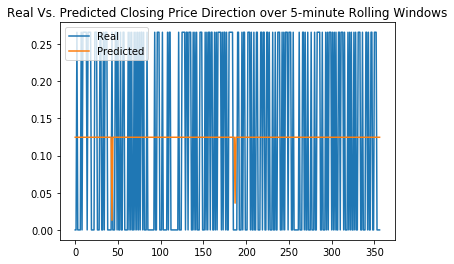

In [353]:
# Plot the real vs predicted values as a line chart
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
positive_sentiments.plot(title=f"Real Vs. Predicted Closing Price Direction over 5-minute Rolling Windows")
plt.savefig('positive_sentiments_5min.png')
plt.show()

<Figure size 432x288 with 0 Axes>

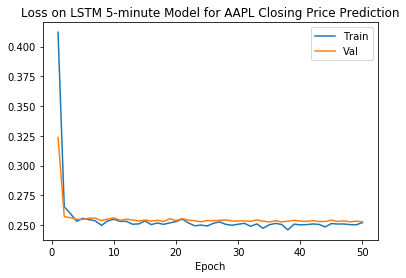

In [354]:
# Plotting loss
epochs = 50
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["loss"],
        "Val": training_history.history["val_loss"],
    }
)
loss_df.set_index("Epoch", inplace=True)

plt.figure()
loss_df.plot(title=f"Loss on LSTM 5-minute Model for {ticker} Closing Price Prediction")
plt.savefig(f'{ticker}_loss_positive_sentiments_5min.png')
plt.show()

<Figure size 432x288 with 0 Axes>

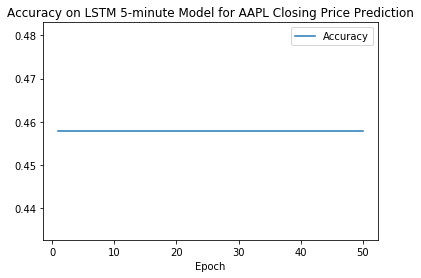

In [355]:
# Plot the accuracy
# Plotting loss
epochs = 50
accuracy_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Accuracy": training_history.history["val_accuracy"],
    }
)
accuracy_df.set_index("Epoch", inplace=True)

plt.figure()
accuracy_df.plot(title=f"Accuracy on LSTM 5-minute Model for {ticker} Closing Price Prediction")
plt.savefig(f'{ticker}_accuracy_positive_sentiments_5min.png')
plt.show()